Files already downloaded and verified
Files already downloaded and verified


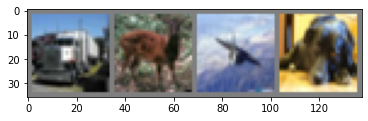

truck  deer plane   dog


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Basic CNN

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

print("Training complete!")

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print("File saved.")

[1,  2000] loss: 2.171
[1,  4000] loss: 1.841
[1,  6000] loss: 1.681
[1,  8000] loss: 1.596
[1, 10000] loss: 1.534
[1, 12000] loss: 1.477
[2,  2000] loss: 1.403
[2,  4000] loss: 1.370
[2,  6000] loss: 1.362
[2,  8000] loss: 1.327
[2, 10000] loss: 1.286
[2, 12000] loss: 1.270
[3,  2000] loss: 1.181
[3,  4000] loss: 1.216
[3,  6000] loss: 1.214
[3,  8000] loss: 1.196
[3, 10000] loss: 1.175
[3, 12000] loss: 1.154
[4,  2000] loss: 1.098
[4,  4000] loss: 1.115
[4,  6000] loss: 1.100
[4,  8000] loss: 1.105
[4, 10000] loss: 1.085
[4, 12000] loss: 1.085
[5,  2000] loss: 1.009
[5,  4000] loss: 1.033
[5,  6000] loss: 1.021
[5,  8000] loss: 1.045
[5, 10000] loss: 1.046
[5, 12000] loss: 1.043
[6,  2000] loss: 0.955
[6,  4000] loss: 0.962
[6,  6000] loss: 0.985
[6,  8000] loss: 0.986
[6, 10000] loss: 0.992
[6, 12000] loss: 0.996
[7,  2000] loss: 0.920
[7,  4000] loss: 0.908
[7,  6000] loss: 0.925
[7,  8000] loss: 0.941
[7, 10000] loss: 0.961
[7, 12000] loss: 0.950
[8,  2000] loss: 0.840
[8,  4000] 

## MobileNet v2

### Source
https://github.com/tinyalpha/mobileNet-v2_cifar10/blob/master/network.py

In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseBlock(nn.Module)

ModuleNotFoundError: No module named 'blocks'

## Test

In [3]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
print(outputs)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

tensor([[ 1.0249,  1.2460, -0.0308, -0.8908, -0.6711, -1.2387, -1.5803, -0.4489,
          1.4060,  1.2544],
        [-0.9955, -2.9098,  1.8376,  1.0587,  1.7281,  1.0131,  1.7166,  0.9792,
         -1.5608, -2.4705],
        [ 1.0249,  1.2460, -0.0308, -0.8908, -0.6711, -1.2387, -1.5803, -0.4489,
          1.4060,  1.2544],
        [-0.9192, -0.9590,  0.7804,  0.8575, -0.0347,  1.0314,  0.8719,  0.7913,
         -1.1484, -1.2684]], grad_fn=<AddmmBackward>)
Predicted:   ship  bird  ship   dog
Accuracy of the network on the 10000 test images: 21 %
